In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.spatial.distance import pdist, squareform
import math
import collections

In [2]:
path = '../fma_metadata/'

tracks = pd.read_csv(path+'tracks.csv', index_col=0, header=[0, 1])
echonest = pd.read_csv(path+'echonest.csv', index_col=0, header=[0, 1, 2])

# Features selected and extracted
audio_features = echonest.echonest.audio_features[['acousticness','danceability','instrumentalness']]
genres = tracks.track[['genres', 'genre_top']]

# Show all the genres of music
features_and_genres = audio_features.merge(genres, left_on='track_id', right_on='track_id', how='inner')
features_and_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

In [3]:
# Select the genres that you want in your graph 
# Add them in the "selected genres" down below
#

selected_genres_full = ['Rock', 'Electronic', 'Hip-Hop', 'Pop', 'Classical', 'Jazz', 'International']
selected_genres = ['Pop', 'Classical', 'Jazz', 'International']

features = features_and_genres[features_and_genres.genre_top == selected_genres[0]]

for i in range(len(selected_genres)-1):
    features = pd.concat([features, (features_and_genres[features_and_genres.genre_top == selected_genres[i+1]])])
    
features = features.drop(columns=['genres','genre_top'])
# keep only numerical data now that the selection according to genres is done
features.head()

,acousticness,danceability,instrumentalness
track_id,,,
10,0.951670,0.658179,0.965427
213,0.933741,0.312720,0.919242
821,0.400494,0.862510,0.908926
822,0.674356,0.870449,0.886045
823,0.212799,0.828657,0.887106


In [4]:
distances = pdist(features.values, metric='euclidean')
# weights computed with a kernel and removing all the weights below threshold
threshold_full = 0.99
threshold = 0.999

# Gaussian kernel: 
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
weights[weights < threshold] = 0
adjacency = squareform(weights)# the adjacency matrix
n_nodes = len(features)

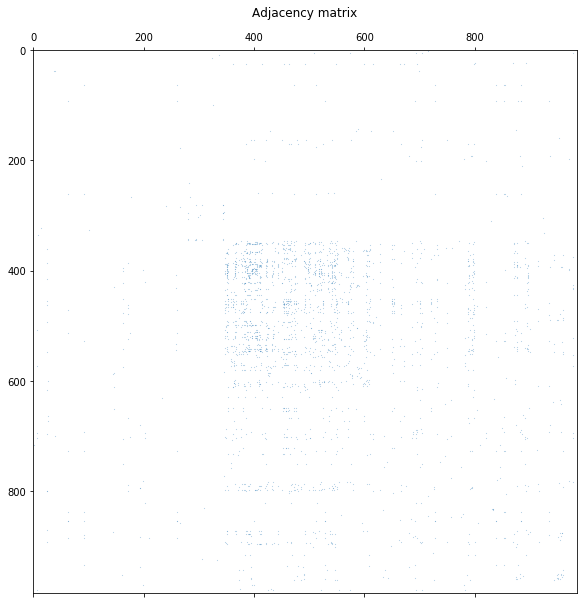

In [5]:
figure1 = plt.figure(figsize=(10, 10))
plt.spy(adjacency, markersize=0.08, figure = figure1)
plt.title('Adjacency matrix')
plt.show()

In [10]:
def matrix_to_list(matrix):
    adj_list = {}
    for i, node in enumerate(matrix):
        connected_nodes = []
        for neighbour_id, neighbour_w in enumerate(node):
            if neighbour_w >0:
                connected_nodes.append(neighbour_id)
        adj_list[i] = connected_nodes
    return adj_list

In [11]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """

    adjacency_list = matrix_to_list(adjacency)
    
    visited = set()
    visited.add(0)
    queue = collections.deque([0])
    #collections is a faster queue than a list
    
    while queue:
        node = queue.popleft()
        for neighbour in adjacency_list[node]:
            if neighbour not in visited:
                visited.add(neighbour)
                queue.append(neighbour)
        
    return (len(adjacency)==len(visited))

In [20]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    
    components = []
    comp_ids = []
    start = 0
    if connected_graph(adjacency):
        return adjacency
    else:
        adjacency_list = matrix_to_list(adjacency)
        visited = set([])

        while len(adjacency)!=len(visited)+1:
            comp_visited = set([])
            comp_visited.add(start)
            visited.add(start)
            queue = collections.deque([start])
            #collections is a faster queue than a list

            while queue:
                node = queue.popleft()
                for neighbour in adjacency_list[node]:
                    if neighbour not in visited:
                        comp_visited.add(neighbour)
                        visited.add(neighbour)
                        queue.append(neighbour)
            comp_visited = list(comp_visited)
            comp_ids.append(comp_visited)
            components.append((adjacency[comp_visited,:])[:,comp_visited])
            while start in visited:
                start += 1
        return components, comp_ids

In [23]:
# compute the connected components
components, comp_ids = find_components(adjacency)
# select the biggest components
length = 0
index = 0
for i in range(len(components)):
    if(len(components[i]) > length):
        length = len(components[i])
        index = i
new_adjacency = components[index]
new_ids = comp_ids[index]
    


In [37]:
features.index[new_ids]

Int64Index([28103, 28105, 28107, 28110,  1051, 28111, 28113, 28114, 28115,
            28116,
            ...
            23160, 24831, 24832, 25865, 25867, 28097, 28098, 28099, 28101,
            28102],
           dtype='int64', name='track_id', length=239)

In [6]:
features.to_csv('new_out_features.csv')
np.save('new_adjacency', adjacency)

In [7]:
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
print(n_nodes)
print(n_edges)

985
1218.0
